## File description 

This file is meant to clean and tranform the data already existing to a format that will be used for labelling. Some EDA and feature engineering will be done here but as the data is not labelled, most of it will be done after the labelling.

## 0. Modules and UDFs

In [1]:
import src.viz as sv
import src.useful as su

import sqlite3
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
from datetime import datetime, timedelta
import demoji
from coolname import generate_slug
from urllib.parse import urlparse

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.figure_factory as ff

from tqdm import tqdm

import os
import shutil

from IPython.display import Image

### 0.1 Setting notebook preferences
Setting pandas to not limit the number of displayed columns and connect to the database.

In [2]:
pd.set_option("display.max_columns", None)
pio.templates.default = "plotly_dark"

# Creating SQL database to store all the data for the project
database = "data/main_database.sqlite"
con = sqlite3.connect(database)

In [3]:
# Print all the tables in the database with their size
query = '''
select 
    * 
from sqlite_master'''

df_sqlite_master = pd.read_sql_query('select * from sqlite_master', con)
for tbl in df_sqlite_master['tbl_name']:
    if 'clean' not in tbl: 
        print(tbl, pd.read_sql_query(f'select * from {tbl}', con).shape)

comments (134465, 12)
post_ids (7831, 2)
last_12_posts (363396, 9)
photos (568974, 3)
users (86341, 65)
username_mapping (88697, 2)


Now, each table is going to be cleaned and put in a nice format ready to be used during the data labelling

### 0.2 Changing all usernames names for cooler names

This is to be done on all dataset so better doing it at the beginning

In [4]:
# Loading all dfs and creating a list of it
df_comments = pd.read_sql_query('select distinct * from comments', con)
df_users = pd.read_sql_query('select distinct * from users', con)
df_last12 = pd.read_sql_query('select distinct * from last_12_posts', con)
all_dfs = [df_comments, df_users, df_last12]

# List all usernames
all_usernames = [username for df in all_dfs for username in df['username']]
print(len(all_usernames))
all_usernames = list(set(all_usernames))
print(len(all_usernames))

584202
88697


Creating new name dictionary and save it direclty

In [5]:
# Get a cool name for each of them, run only once
# cooler_name = {username: generate_slug(3) for index, username in enumerate(all_usernames)}
# df_username_mapping = pd.DataFrame([[i, j] for i, j in cooler_name.items()], columns=['username', 'cooler_name'])
# df_username_mapping.to_sql('username_mapping', con, if_exists='fail', index=False)

In [6]:
# Get a cool name for each of them
df_username_mapping = pd.read_sql_query('select * from username_mapping', con)
cooler_names = dict(df_username_mapping.values)


for index, df in enumerate(all_dfs):
    df['cool_username'] = [cooler_names[username] for username in df['username']]

    # Flipping the columns so that username is replaced last
    for column in df.iloc[:, ::-1].columns: 
        if df[column].dtype == 'object':
            try:
                df[column] = df.apply(lambda x: x[column].replace(x['username'], x['cool_username']) if type(x[column]) == str else x['username'], axis=1)
            except Exception as e: 
                print(f'{[name for name in globals() if globals()[name] is all_dfs[index]][0]}, {column} - {e}')
    
    # all_dfs[index] = df 
    sub_df = df.copy()

## 1. Comments

This table contains all the comments collected and each row of the table represent a single comment. It's possible that if a user commented twice on a post, I collected both of the comment or caught the comment of the same users on multiple post.
The goal is to clean the table, and output it in a clean and organized table containing one comment per row.

### 1.1 Load data and quick explore

In [7]:
df_comments.head()

page       postid  \
0  bleacherreport  CYsUBv7KPFR   
1  bleacherreport  CYsUBv7KPFR   
2  bleacherreport  CYsUBv7KPFR   
3  bleacherreport  CYsUBv7KPFR   
4  bleacherreport  CYsUBv7KPFR   

                                              legend     post_likes  \
0  bleacherreportVerifiedThis Bobby Portis celebr...  306,460 likes   
1  bleacherreportVerifiedThis Bobby Portis celebr...  306,460 likes   
2  bleacherreportVerifiedThis Bobby Portis celebr...  306,460 likes   
3  bleacherreportVerifiedThis Bobby Portis celebr...  306,460 likes   
4  bleacherreportVerifiedThis Bobby Portis celebr...  306,460 likes   

           post_posted_time                       username  \
0  2022-01-14T01:41:02.000Z  carrot-mastodon-of-enthusiasm   
1  2022-01-14T01:41:02.000Z       new-statuesque-binturong   
2  2022-01-14T01:41:02.000Z           adorable-jade-beluga   
3  2022-01-14T01:41:02.000Z      hysterical-glistening-bee   
4  2022-01-14T01:41:02.000Z     uber-dragon-of-advertising   

                                   full_comment_data  \
0  carrot-mastodon-of-enthusiasmBRUH THE BUCKS CA...   
1  new-statuesque-binturongBobby Portis shooting ...   
2  adorable-jade-belugaBucks finna have a repeat ...   
3  hysterical-glistening-beeCRAZY EYES GOT MOVES ...   
4  uber-dragon-of-advertisingCan’t wait for fligh...   

                                  comment       comment_posted_time  \
0         BRUH THE BUCKS CANT MISS A SHOT  2022-01-14T01:41:33.000Z   
1  Bobby Portis shooting > Steph shooting  2022-01-14T01:42:49.000Z   
2           Bucks finna have a repeat 🏆 👀  2022-01-14T01:42:37.000Z   
3            CRAZY EYES GOT MOVES LOL 🤣🤣😭  2022-01-14T01:45:12.000Z   
4      Can’t wait for flights reaction 😂😂  2022-01-14T01:45:27.000Z   

  comments_likes  comment_comments_count         data_collected_time  \
0    2,234 likes                       8  2022-01-17 02:18:25.197544   
1    3,011 likes                      24  2022-01-17 02:18:25.199751   
2      967 likes                      43  2022-01-17 02:18:25.200984   
3    1,024 likes                       7  2022-01-17 02:18:25.202163   
4      966 likes                       5  2022-01-17 02:18:25.203335   

                   cool_username  
0  carrot-mastodon-of-enthusiasm  
1       new-statuesque-binturong  
2           adorable-jade-beluga  
3      hysterical-glistening-bee  
4     uber-dragon-of-advertising

In [8]:
df_comments.describe(include='all').round()

page       postid  \
count   134465       134465   
unique      24         5614   
top        nfl  CYh6UW-IWUc   
freq      9544           80   
mean       NaN          NaN   
std        NaN          NaN   
min        NaN          NaN   
25%        NaN          NaN   
50%        NaN          NaN   
75%        NaN          NaN   
max        NaN          NaN   

                                                   legend     post_likes  \
count                                              134465         134465   
unique                                               5593           5579   
top     slamVerifiedThis is a shout out to one of our ...  231,598 likes   
freq                                                   80            120   
mean                                                  NaN            NaN   
std                                                   NaN            NaN   
min                                                   NaN            NaN   
25%                                                   NaN            NaN   
50%                                                   NaN            NaN   
75%                                                   NaN            NaN   
max                                                   NaN            NaN   

                post_posted_time                 username  \
count                     134465                   134465   
unique                      5605                    88594   
top     2022-01-10T00:44:01.000Z  rational-elk-of-respect   
freq                         104                      316   
mean                         NaN                      NaN   
std                          NaN                      NaN   
min                          NaN                      NaN   
25%                          NaN                      NaN   
50%                          NaN                      NaN   
75%                          NaN                      NaN   
max                          NaN                      NaN   

                     full_comment_data comment       comment_posted_time  \
count                           134465  134465                    134465   
unique                          133776  119362                    124263   
top     able-jerboa-of-finesse🔥7wReply     🔥🔥🔥  2022-01-02T18:24:58.000Z   
freq                                 7     234                        10   
mean                               NaN     NaN                       NaN   
std                                NaN     NaN                       NaN   
min                                NaN     NaN                       NaN   
25%                                NaN     NaN                       NaN   
50%                                NaN     NaN                       NaN   
75%                                NaN     NaN                       NaN   
max                                NaN     NaN                       NaN   

       comments_likes  comment_comments_count         data_collected_time  \
count          134465                134465.0                      134465   
unique           7610                     NaN                      134465   
top             Reply                     NaN  2022-01-17 02:18:25.197544   
freq            16003                     NaN                           1   
mean              NaN                     7.0                         NaN   
std               NaN                    22.0                         NaN   
min               NaN                     0.0                         NaN   
25%               NaN                     0.0                         NaN   
50%               NaN                     1.0                         NaN   
75%               NaN                     7.0                         NaN   
max               NaN                  2543.0                         NaN   

                  cool_username  
count                    134465  
unique                    88594  
top     rational-elk-of-respect  
freq             

In [9]:
df_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134465 entries, 0 to 134464
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   page                    134465 non-null  object
 1   postid                  134465 non-null  object
 2   legend                  134465 non-null  object
 3   post_likes              134465 non-null  object
 4   post_posted_time        134465 non-null  object
 5   username                134465 non-null  object
 6   full_comment_data       134465 non-null  object
 7   comment                 134465 non-null  object
 8   comment_posted_time     134465 non-null  object
 9   comments_likes          134465 non-null  object
 10  comment_comments_count  134465 non-null  int64 
 11  data_collected_time     134465 non-null  object
 12  cool_username           134465 non-null  object
dtypes: int64(1), object(12)
memory usage: 13.3+ MB


Luckily no duplicates, some columns as likes and comment likes need to be integers, others as the dates need to me in a date format.

* There are 134.465 rows of data, meaning the same number of comments
* Total of 88608 users meaning an average of 1.5 comment per user
* Post likes and comment need the numbers to be extracted and columns changed to integer 
* The three date columns don't have a correct type
* Some columns names are not explicit enough, might need to change them
* Some columns are irrelevant to this analysis. For example, the legend of the post will have no effect on the bot/non bot user so there is no point of keeping them
* No missing values! :emoji_dab:

### 1.2 Removing irrelevant columns & column names

I collected too much data, some columns are irrelevant to the analysis or the model develoment as the page, postid, post_likes and others are independant from the bots.

In [10]:
df_comments.drop_duplicates().shape[0], df_comments.shape[0]

(134465, 134465)

In [11]:
df_old_comments = df_comments.copy()

df_old_comments.duplicated(keep=False).sum()

0

In [12]:
df_comments = df_comments.rename({'legend': 'caption',
                                  'comments_likes': 'comment_likes',
                                  'comment_comments_count': 'comment_reply_count'}, axis=1)

# Removing irrelevant columns and changing the columns order
df_comments = df_comments[["username", "comment", "comment_likes", "comment_posted_time", "post_posted_time"]].drop_duplicates()

df_comments.head(0)

Empty DataFrame
Columns: [username, comment, comment_likes, comment_posted_time, post_posted_time]
Index: []

### 1.3 Verified usernames  

When collecting the data, I didn't see that when colelcting the username of the verified users, I was also adding 'Verified' to it as it was probably in the html and didn't see. (done before replacing usernames by cool names...)

In [13]:
print('Number accounts finishing by Verified')
df_comments.query('username.str.endswith("Verified")')['username'].unique().shape

Number accounts finishing by Verified


(0,)

In [14]:
# Creating Verified flag
df_comments['verified_user'] = df_comments['username'].apply(lambda x: 1 if 'Verified' in x else 0).astype(int)

# Removing Verified from username
df_comments['username'] = df_comments['username'].apply(lambda x: x[:-8] if x[-8:]=="Verified" else x)

print('Number accounts finishing by Verified')
df_comments.query('username.str.endswith("Verified")')['username'].unique().shape

Number accounts finishing by Verified


(0,)

### 1.4 Posted time

Both posted time columns don't have the proper datatype, they need to be datetime. Itself they don't help much but I can subtract both date and know how many seconds after the post has been posted, the comment has been too. 

the column comment posted time is very important as many users spam the same commment and have 0-0 likes accros the tries, keeping the columns comment posted time prevent from removing fake duplicated.

In [15]:
# Changing columns to datetime type
df_comments["post_posted_time"] = pd.to_datetime(df_comments["post_posted_time"])
df_comments["comment_posted_time"] = pd.to_datetime(df_comments["comment_posted_time"])

# Getting time diff and removing posted time columns
df_comments["time_difference"] = (df_comments["comment_posted_time"] - df_comments["post_posted_time"]).dt.seconds
df_comments = df_comments.drop(["post_posted_time"], axis=1)

df_comments.head()

username                                 comment  \
0  carrot-mastodon-of-enthusiasm         BRUH THE BUCKS CANT MISS A SHOT   
1       new-statuesque-binturong  Bobby Portis shooting > Steph shooting   
2           adorable-jade-beluga           Bucks finna have a repeat 🏆 👀   
3      hysterical-glistening-bee            CRAZY EYES GOT MOVES LOL 🤣🤣😭   
4     uber-dragon-of-advertising      Can’t wait for flights reaction 😂😂   

  comment_likes       comment_posted_time  verified_user  time_difference  
0   2,234 likes 2022-01-14 01:41:33+00:00              0               31  
1   3,011 likes 2022-01-14 01:42:49+00:00              0              107  
2     967 likes 2022-01-14 01:42:37+00:00              0               95  
3   1,024 likes 2022-01-14 01:45:12+00:00              0              250  
4     966 likes 2022-01-14 01:45:27+00:00              0              265

In [16]:
df_comments['time_difference'].describe().round().to_frame()

time_difference
count         134226.0
mean            3291.0
std            11381.0
min                3.0
25%               70.0
50%              194.0
75%              596.0
max            86394.0

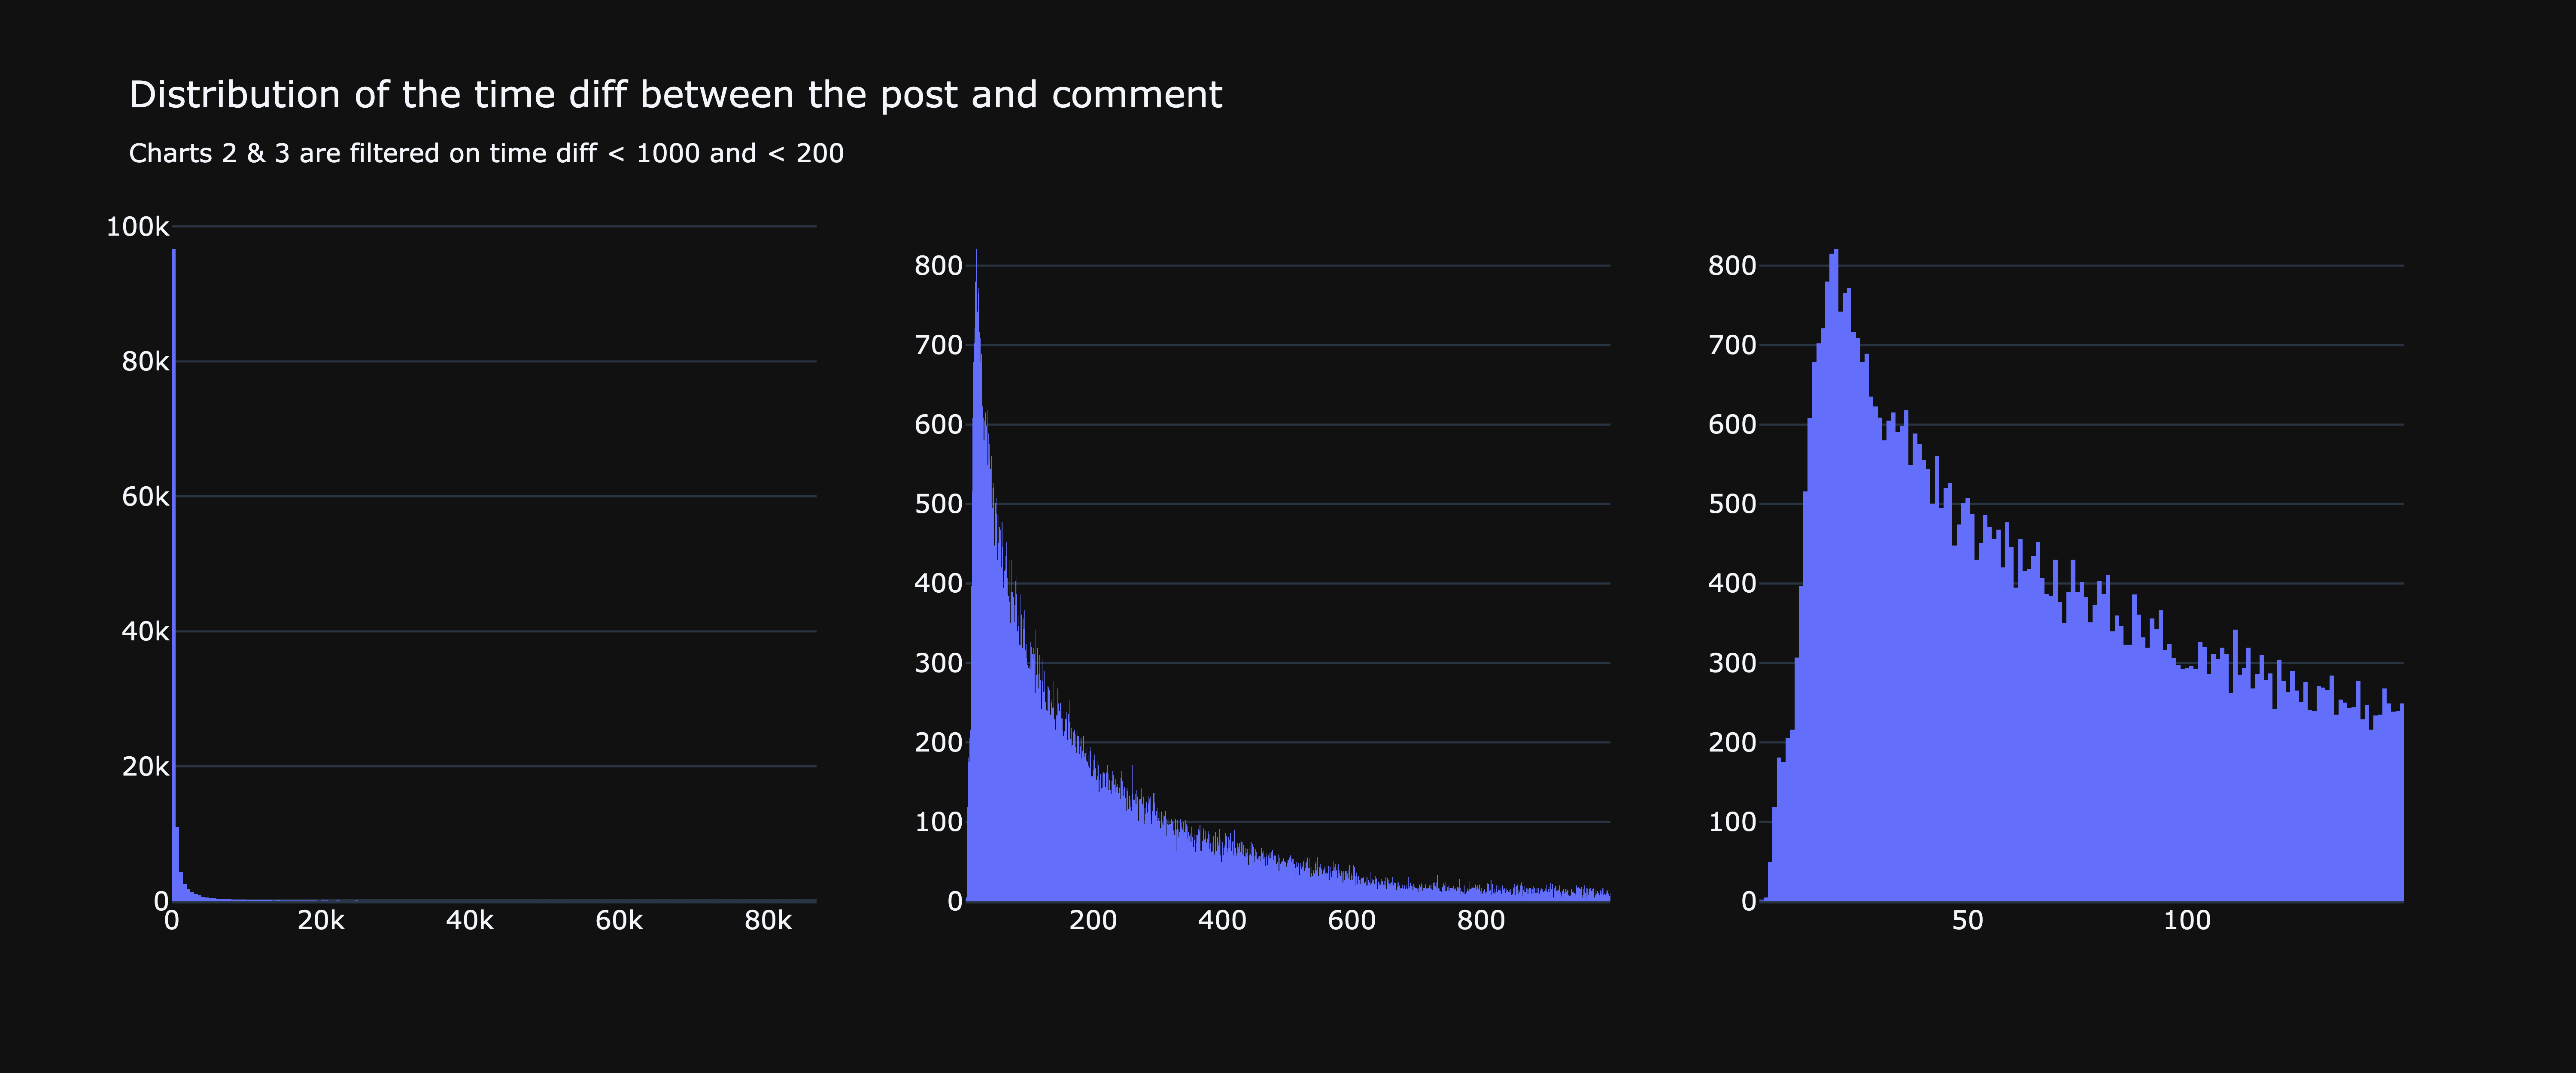

In [17]:
# Show distribution of the comments and the time difference
fig1 = px.histogram(df_comments, 
                    x = 'time_difference')
                    
fig2 = px.histogram(df_comments.query('time_difference < 1000'), 
                    x = 'time_difference', 
                    nbins = 1000)

fig3 = px.histogram(df_comments.query('time_difference < 150'), 
                    x = 'time_difference',
                    nbins=150)


# Join figures
fig_join = sv.join_plots([fig1, fig2, fig3],
                         title='Distribution of the time diff between the post and comment',
                         subtitle='Charts 2 & 3 are filtered on time diff < 1000 and < 200')

# Save chart
file_name = 'Distribution of the time diff between the post and comment - Dual Histogram lt 1000'
sv.save_plotly(fig_join, file_name, 'image')

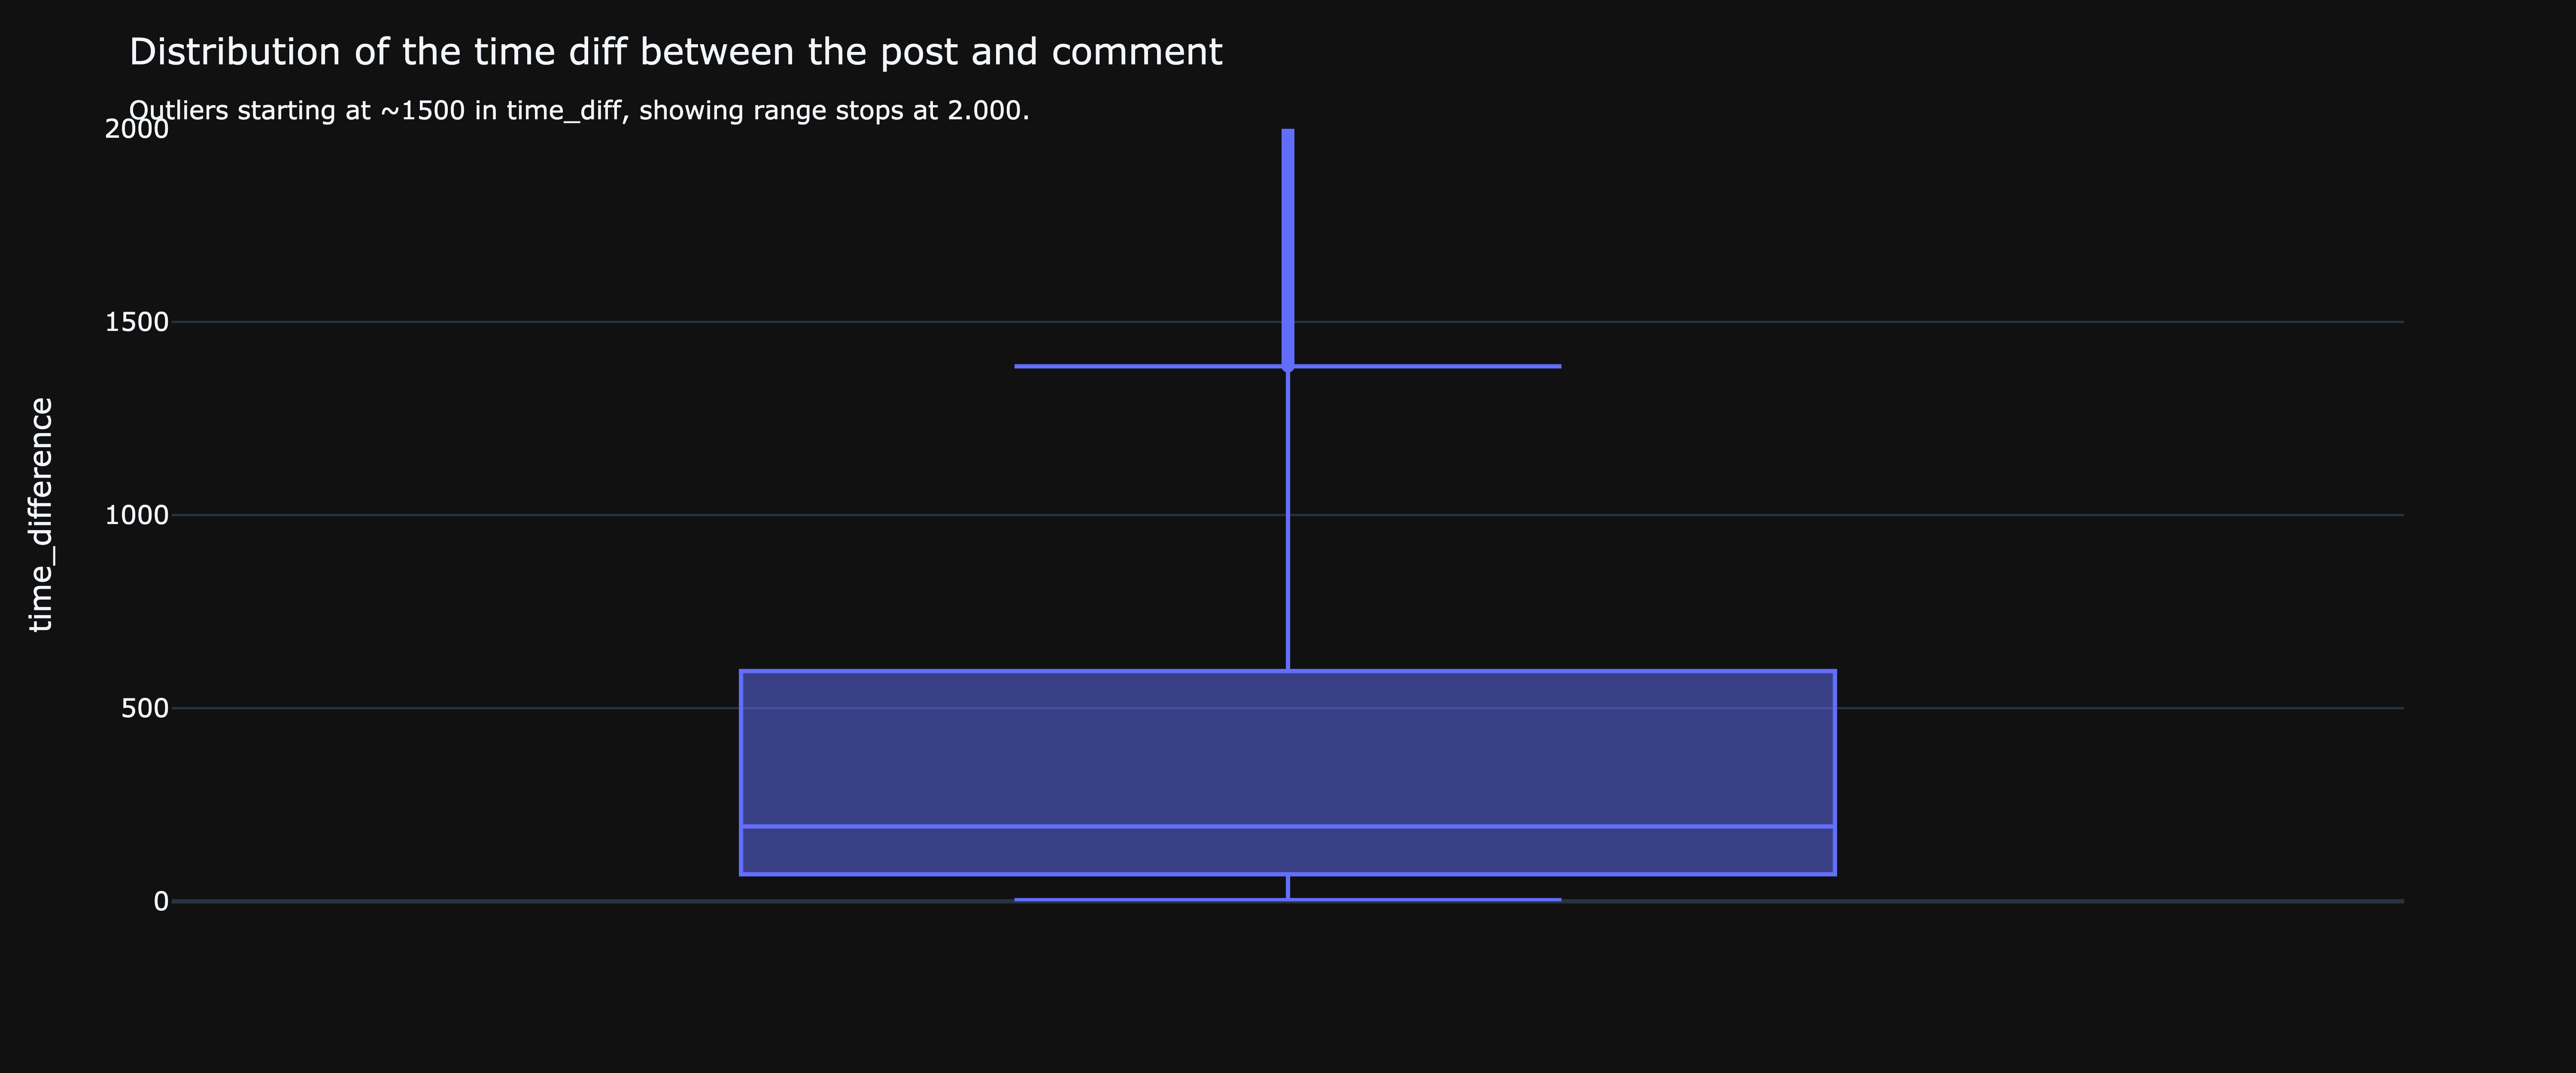

In [18]:
# Create box plot 
fig = px.box(df_comments, y="time_difference")
fig.update_layout(yaxis_range=(0, 2000), # Don't show the chart above 1000 seconds
                  title='Distribution of the time diff between the post and comment<br><sub>Outliers starting at ~1500 in time_diff, showing range stops at 2.000.')


# Save chart
file_name = 'Distribution of the time diff between the post and comment - Dual Histogram lt 500'
sv.save_plotly(fig, file_name, 'image')

For most of the comments collected, 75% have been posted in the first 10 minutes after the post has been posted. The median is a third of that, half of the comments were posted in the first three minutes. The peak of the most comments posted at the same time happends 19-20 seconds after the post is published. Once the users are labelled, it'll be interesting to see the difference in that 0-20 seconds window to see the ratio of bots compared to later. The data is not representative of all Instagram data as when collecting it, I was starting collecting the first IG was showing, the ones with the most likes.

### 1.5 Comment likes
The like columns is string containing the number of likes formated with thousand commas followed by 'Likes'. The column should be and ineger without any character being non numeric

In [19]:
print('With likes')
display(df_comments['comment_likes'].head())
print('Without likes')
df_comments.query('comment_likes.str.contains("like")==False')['comment_likes'].head()

With likes


0    2,234 likes
1    3,011 likes
2      967 likes
3    1,024 likes
4      966 likes
Name: comment_likes, dtype: object

Without likes


23     Reply
104    Reply
107    Reply
176    Reply
178    Reply
Name: comment_likes, dtype: object

In [20]:
# Replacing 'Reply' by '0' and then extracting all numbers from the strings
df_comments.loc[df_comments['comment_likes']=='Reply', 'comment_likes'] = '0'
df_comments['comment_likes'] = df_comments['comment_likes'].str.replace('\D+', '', regex=True).astype(int)
df_comments.head()

username                                 comment  \
0  carrot-mastodon-of-enthusiasm         BRUH THE BUCKS CANT MISS A SHOT   
1       new-statuesque-binturong  Bobby Portis shooting > Steph shooting   
2           adorable-jade-beluga           Bucks finna have a repeat 🏆 👀   
3      hysterical-glistening-bee            CRAZY EYES GOT MOVES LOL 🤣🤣😭   
4     uber-dragon-of-advertising      Can’t wait for flights reaction 😂😂   

   comment_likes       comment_posted_time  verified_user  time_difference  
0           2234 2022-01-14 01:41:33+00:00              0               31  
1           3011 2022-01-14 01:42:49+00:00              0              107  
2            967 2022-01-14 01:42:37+00:00              0               95  
3           1024 2022-01-14 01:45:12+00:00              0              250  
4            966 2022-01-14 01:45:27+00:00              0              265

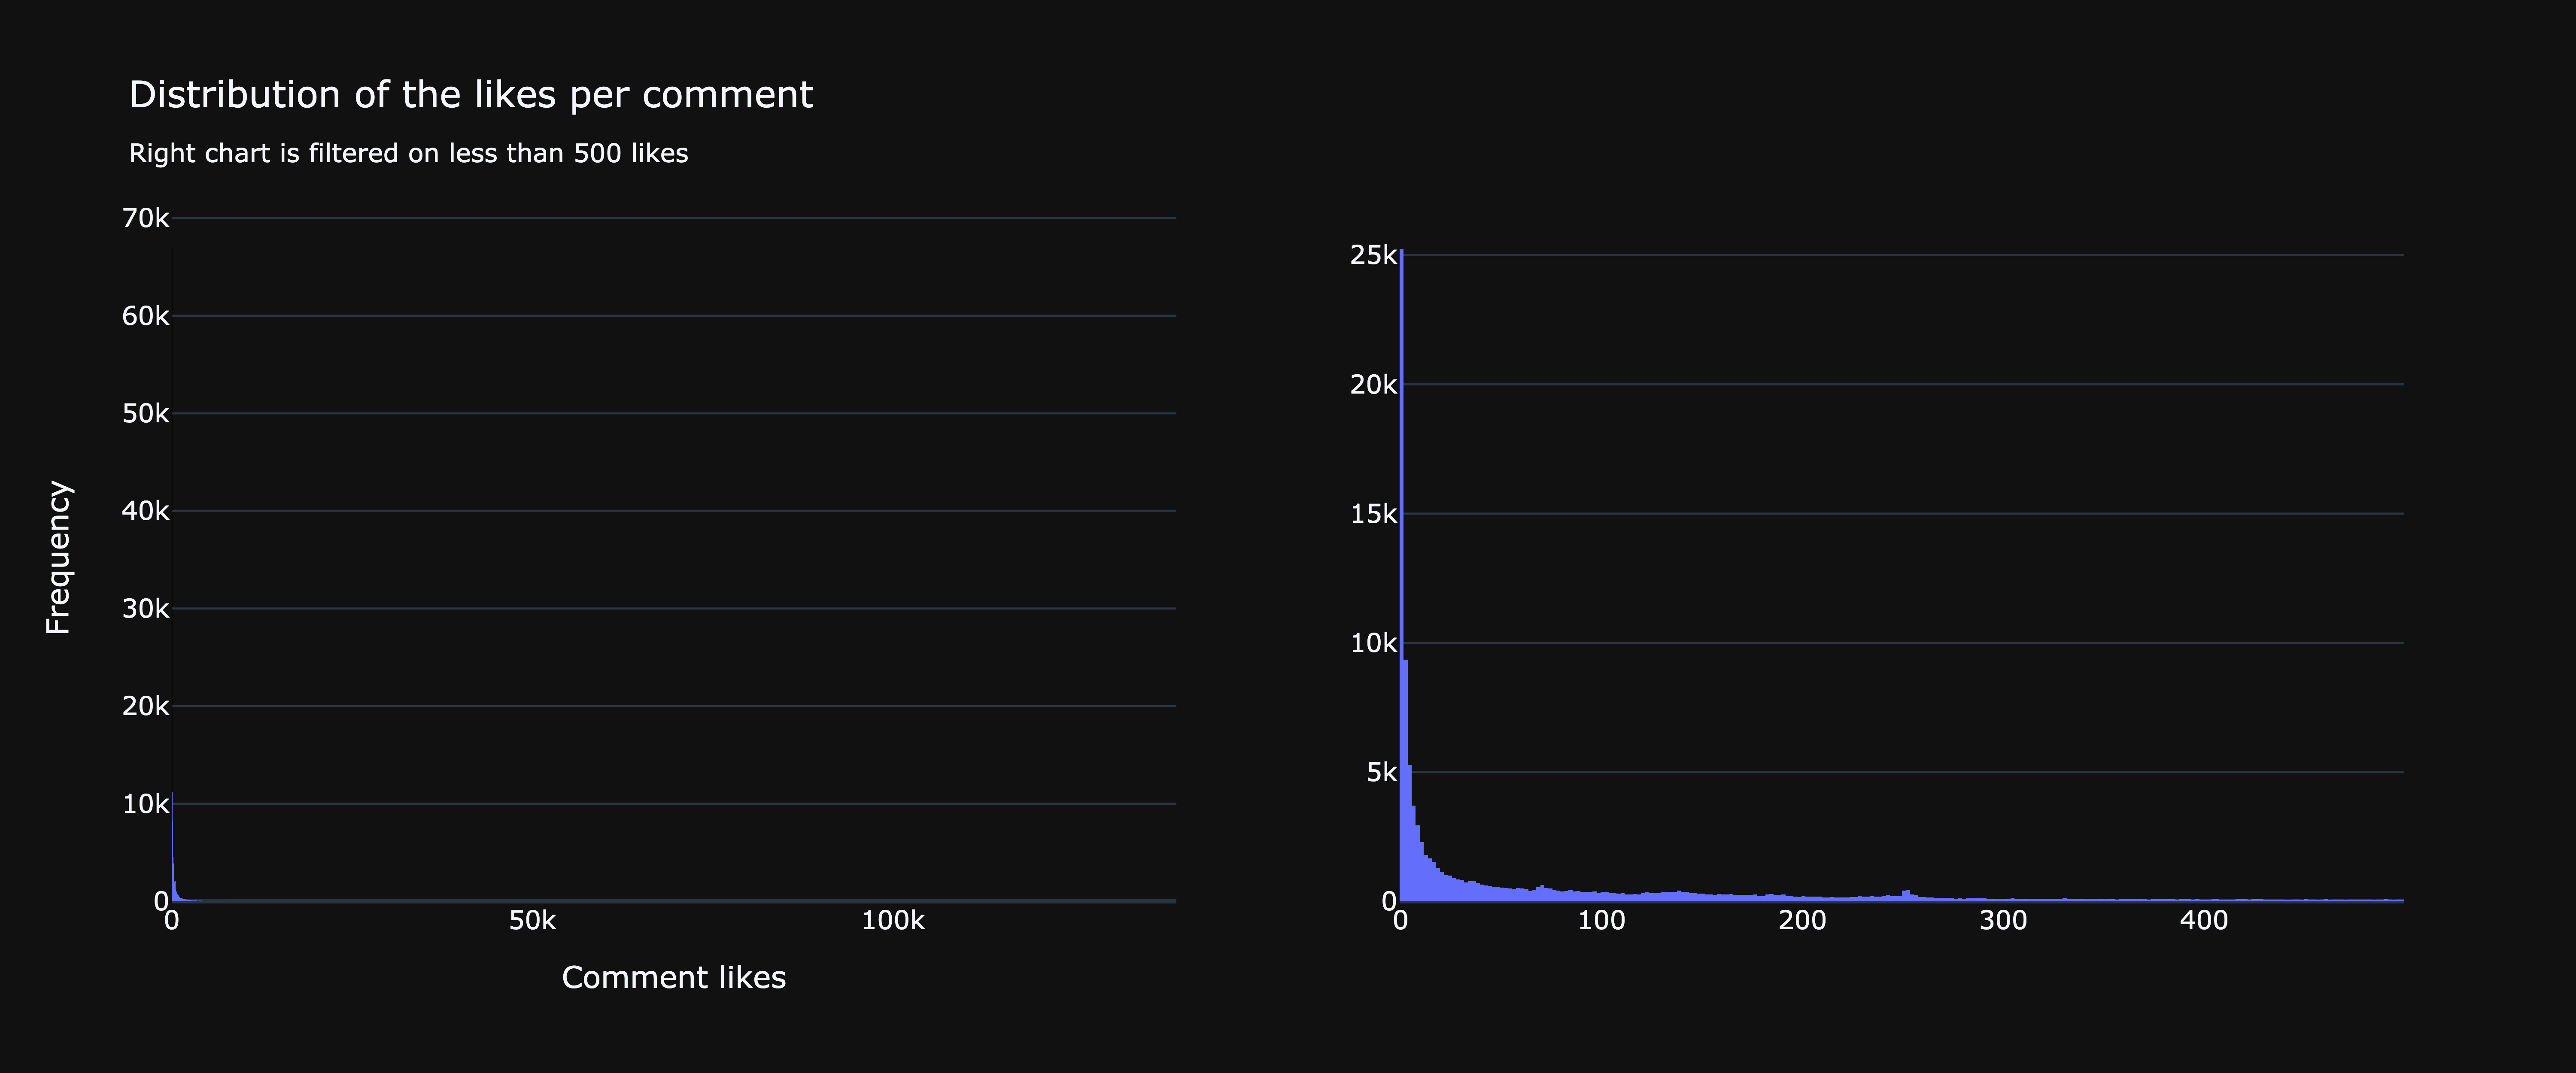

In [21]:
# Show distribution of the comments and the time difference
fig1 = px.histogram(df_comments, 
                    x = 'comment_likes')
                    
fig2 = px.histogram(df_comments.query('comment_likes < 500'), 
                    x = 'comment_likes', 
                    nbins = 400)


fig_join = sv.join_plots([fig1, fig2],
                         title='Distribution of the likes per comment',
                         subtitle='Right chart is filtered on less than 500 likes')

# Update axis names
fig_join.update_layout(xaxis_title="Comment likes",
                       yaxis_title="Frequency")

# Save chart
file_name = 'Distribution of the likes per comment - Dual Histogram lt 500'
sv.save_plotly(fig_join, file_name, 'image')

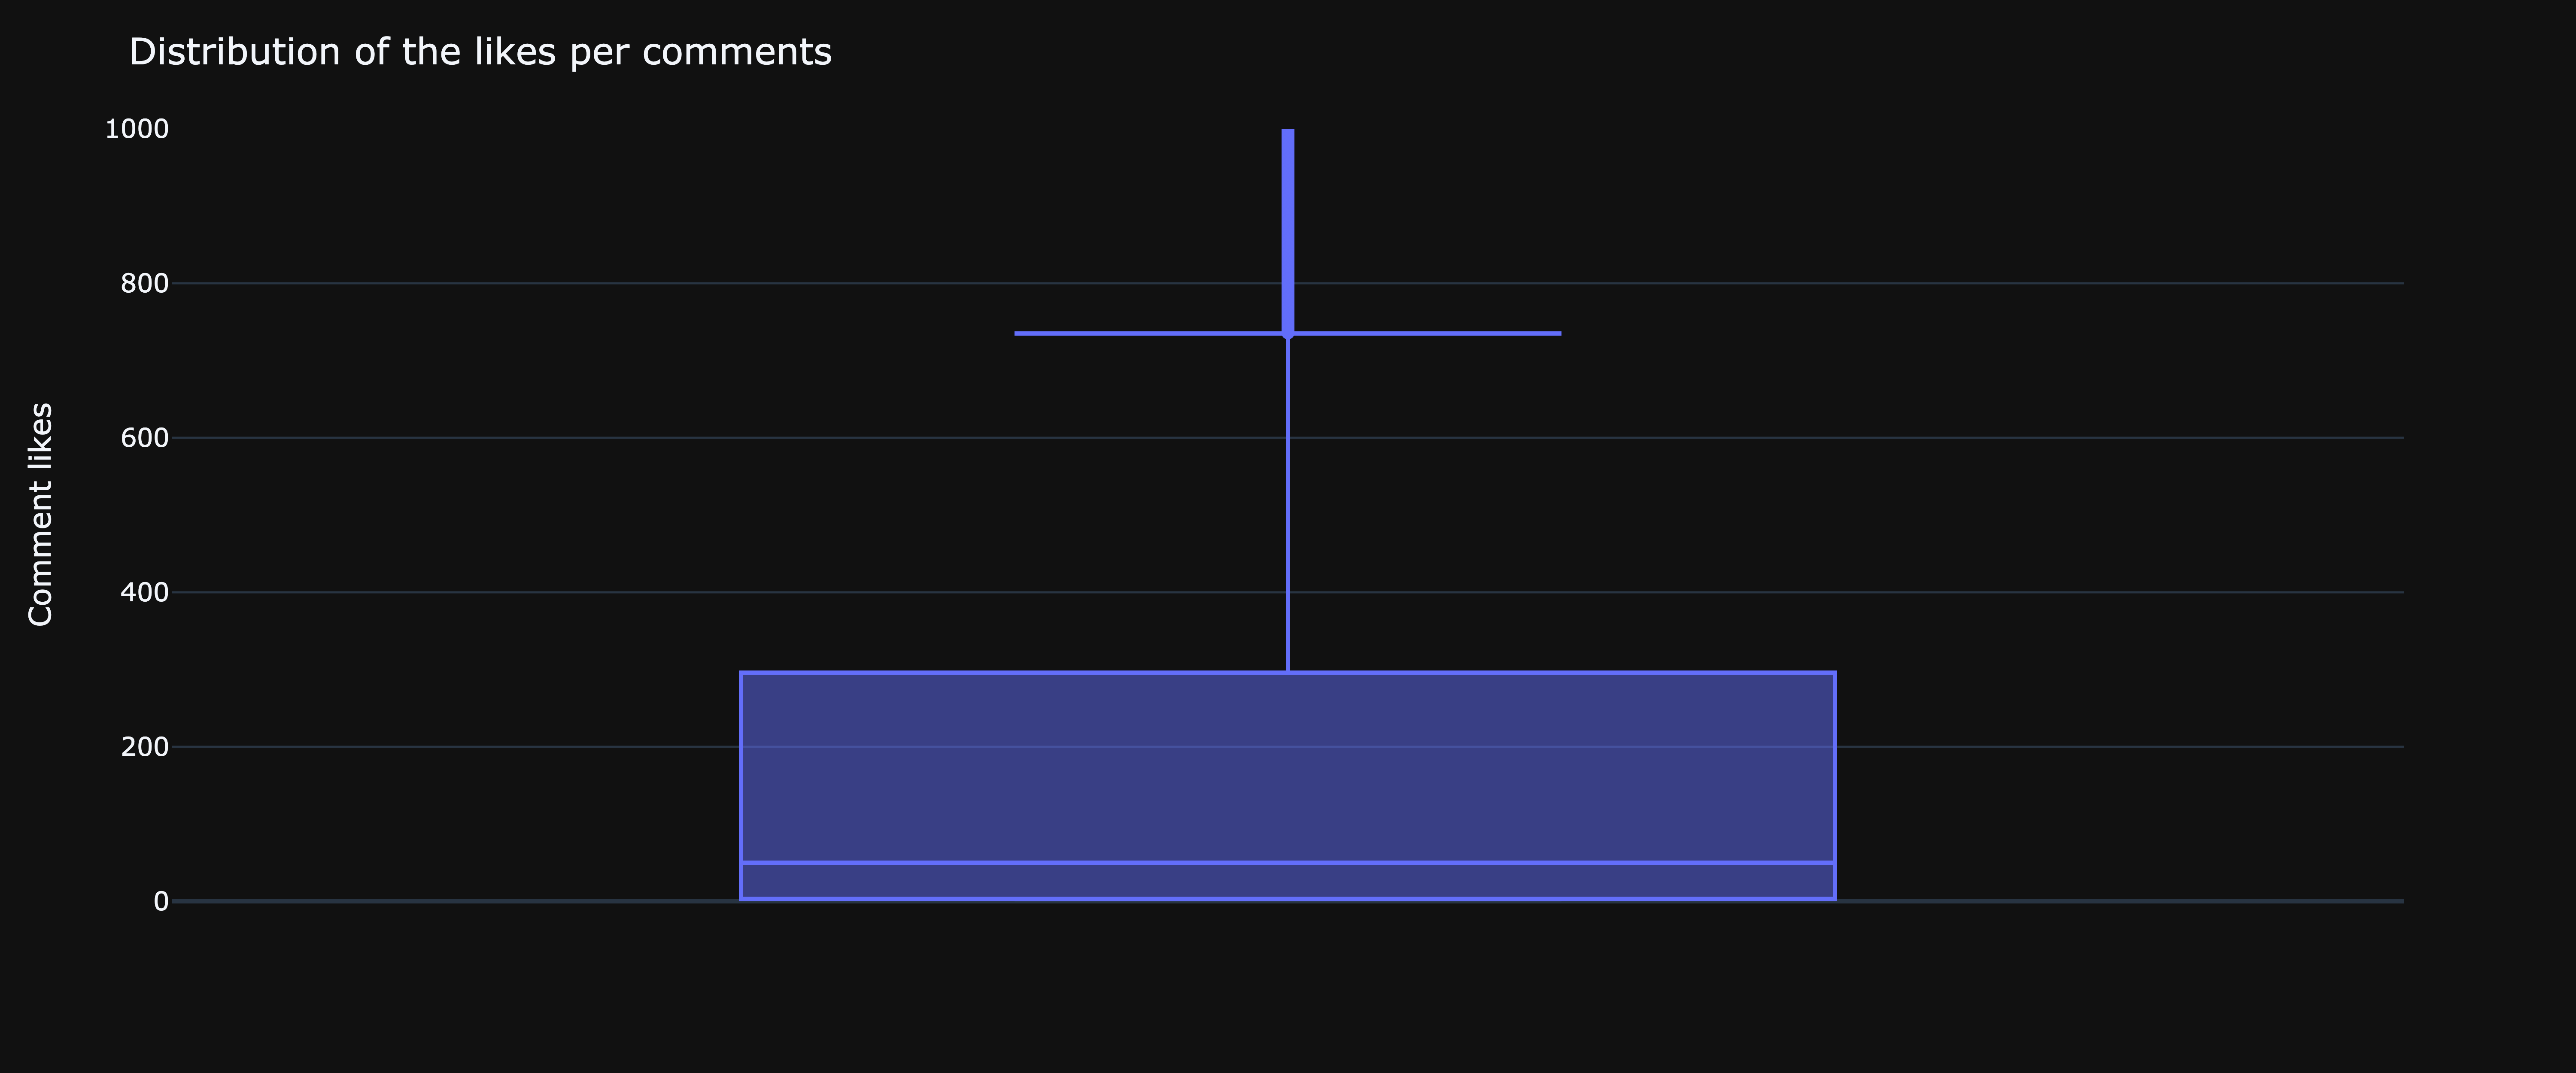

In [22]:
# Create box plot 
fig = px.box(df_comments, 
             y="comment_likes")

fig.update_layout(title='Distribution of the likes per comments', 
                  yaxis_range=(0, 1000), # Don't show the chart above 1000 seconds
                  yaxis_title="Comment likes") 


# Save chart
file_name = 'Distribution of the likes per comment - box plot'
sv.save_plotly(fig, file_name, 'image')

75% of the comments have less than 295 likes with half less than 50 likes. Let's look at the relationship with likes and how it varies depending on when the comment has been posted. 

In [23]:
# The user table is not yet clean but I can still get the follower count of all users
query = '''
select 
    distinct 
    username
    , edge_followed_by_count as follower_count
from users
'''

df_users_follow_count = pd.read_sql_query(query, con)

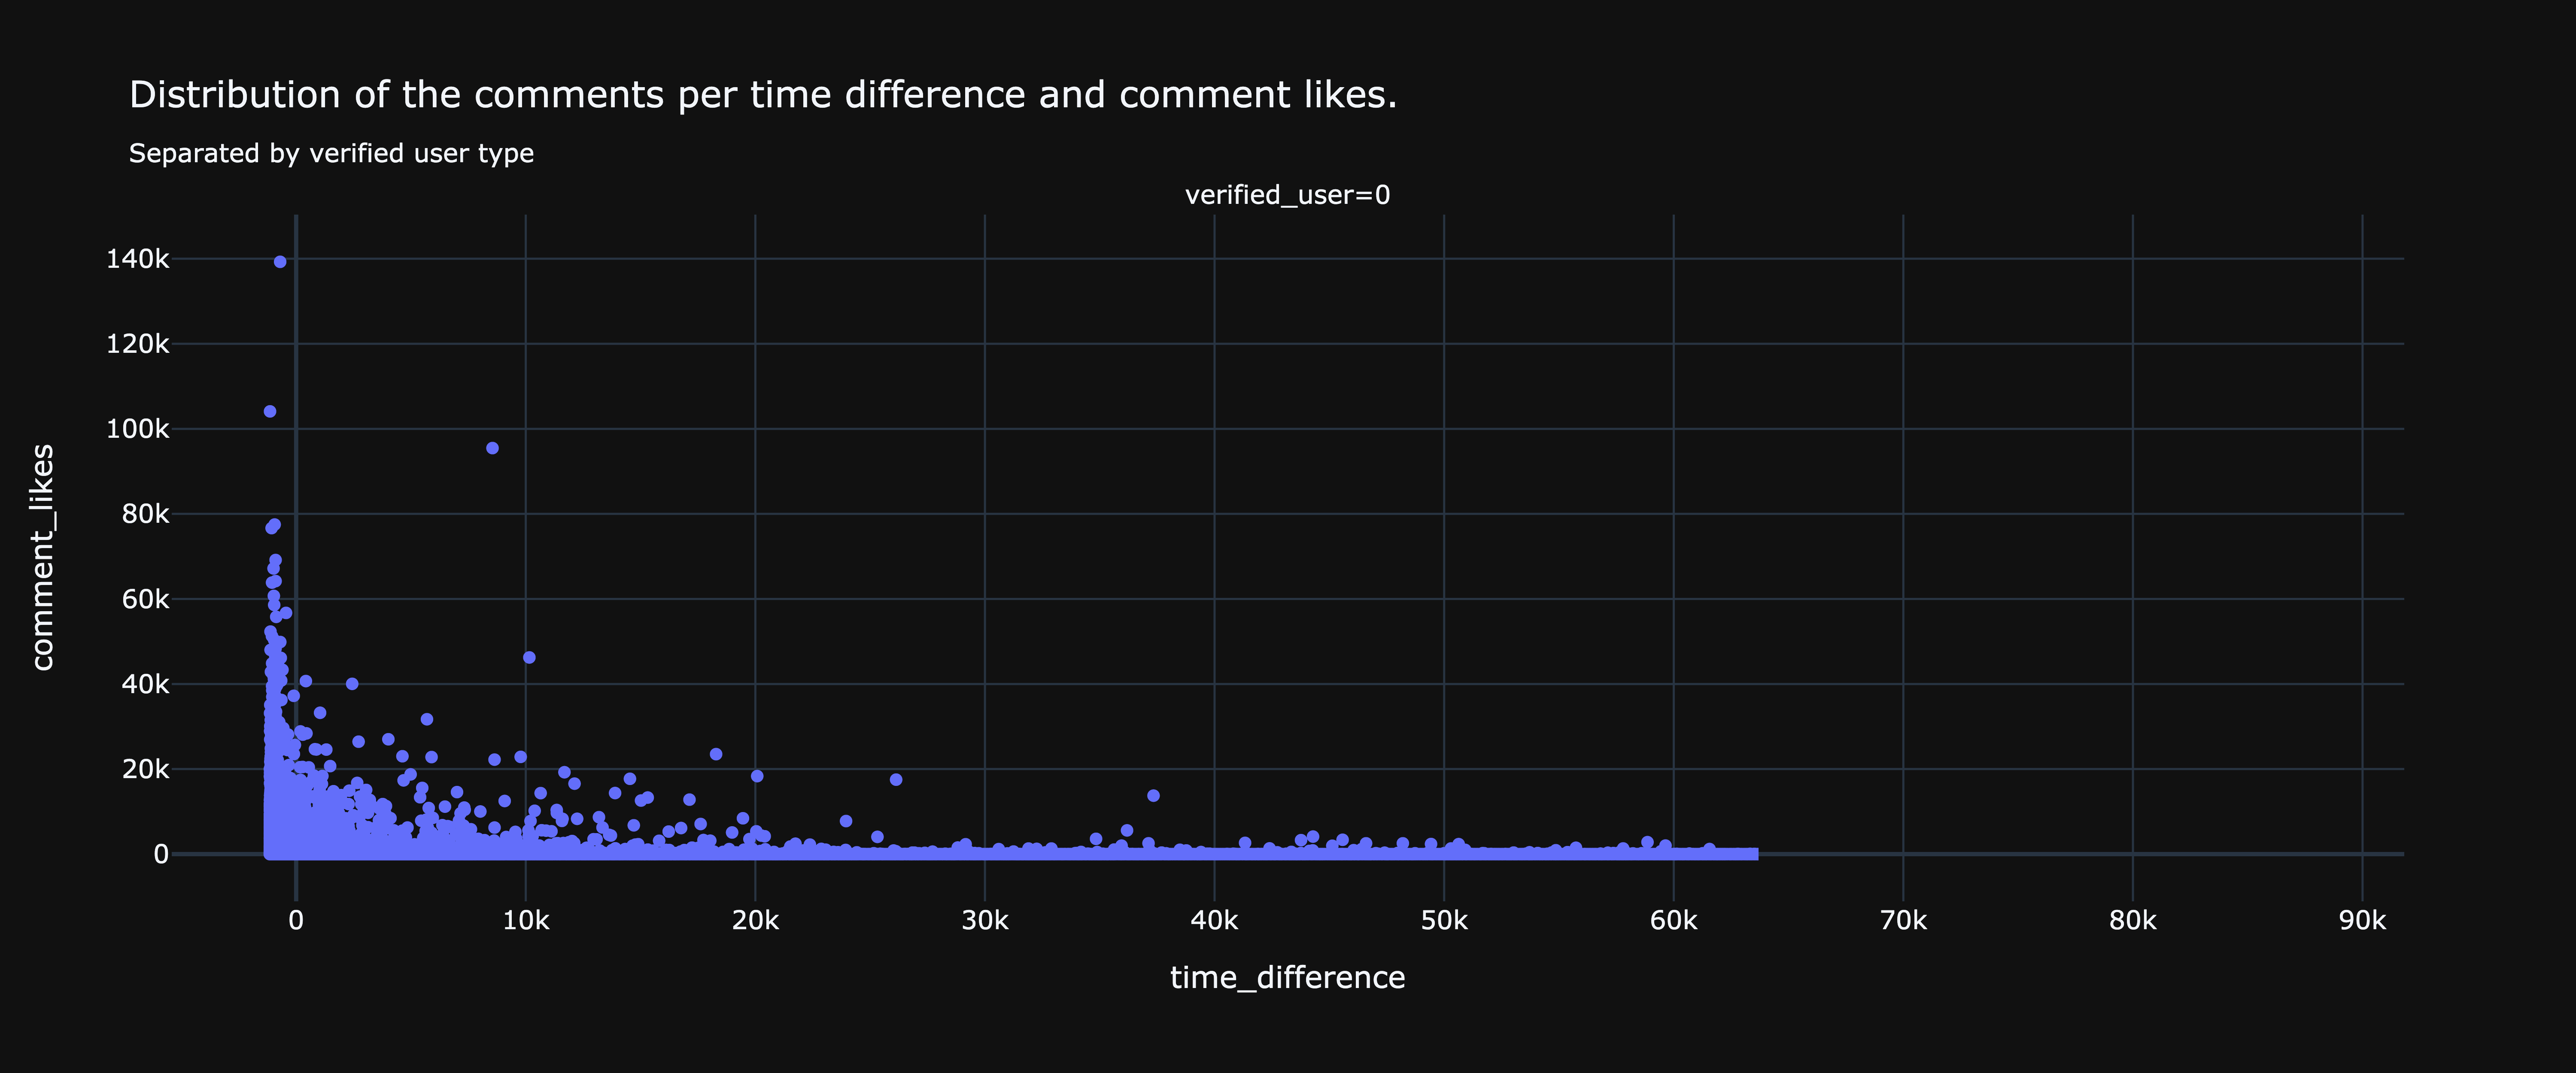

In [24]:
fig = px.scatter(df_comments, 
                 x='time_difference', 
                 y='comment_likes', 
                 facet_col='verified_user',
                 title = 'Distribution of the comments per time difference and comment likes.<br><sub>Separated by verified user type')


# Export
file_name = 'Time difference vs comment likes - Dual scatter verified users'
sv.save_plotly(fig, file_name, 'image')

There is a general trend, the more time after the post is posted you comment, the less likes you will have. This is because there are already a bunch of poeple that have seen the post before the late comment so less potential like count. Except in rare situations, this is always the case for non verified users, they always have low likes if they don't comment at the beginning. For verified users, it's not the same as they ahave their followers naturally liking their comment or the page owner commenting on its own post. It'll be interesting to see how the distribution changes for bots/legit users.

### 1.6 Comment content

* While scraping the comments, I also collect the button name right under and collected in some comments 'Hide replies' and 'Reply'.
* Many comments have emojis

In [25]:
df_comments.query('comment.str.contains("Hide replies|Reply")').head()

username  \
12      melodic-economic-turaco   
17     roaring-taipan-of-action   
19        naughty-rebel-penguin   
20  feathered-pragmatic-peccary   
33       aquatic-polar-mackerel   

                                              comment  comment_likes  \
12                 Stop it , they dead already 😂Reply            235   
17                                  DelightfullyReply            252   
19                                           Hi👑Reply            131   
20  @andresvillalonm @fer_villalon @rorortega_3 Cr...              1   
33         His dad looked pissed after that TD 😂Reply            384   

         comment_posted_time  verified_user  time_difference  
12 2022-01-14 01:44:06+00:00              0              184  
17 2022-01-14 01:41:40+00:00              0               38  
19 2022-01-14 01:41:25+00:00              0               23  
20 2022-01-14 02:10:31+00:00              0             1769  
33 2022-01-17 16:02:27+00:00              0              373

In [26]:
# Removing hide replies and reply from the comment
df_comments["comment"] = df_comments["comment"].apply(lambda x: x[:-12] if x[-12:]=="Hide replies" else x)
df_comments["comment"] = df_comments["comment"].apply(lambda x: x[:-5] if x[-5:]=="Reply" else x)

In [27]:
df_comments.query('comment.str.contains("Hide replies|Reply")')

Empty DataFrame
Columns: [username, comment, comment_likes, comment_posted_time, verified_user, time_difference]
Index: []

In [28]:
# Adding a column with emoji count of the comments
df_comments["emoji_dict"] = df_comments["comment"].apply(lambda x: su.count_emoji(x))

# Adding the count of distinct emoji and the count of emojis in total
df_comments["emoji_count"] = df_comments["emoji_dict"].apply(lambda x: sum(x.values()))
df_comments["emoji_count_distinct"] = df_comments["emoji_dict"].apply(lambda x: len(x.keys()))

# Removing emoji from comments
df_comments["comment_wo_emoji"] = df_comments["comment"].apply(lambda x: demoji.replace(x, "").strip())

# # Adding a columns containing all emojis
df_comments["emoji"] = df_comments["emoji_dict"].apply(lambda x: ''.join(x.keys()))

df_comments.head()

username                                 comment  \
0  carrot-mastodon-of-enthusiasm         BRUH THE BUCKS CANT MISS A SHOT   
1       new-statuesque-binturong  Bobby Portis shooting > Steph shooting   
2           adorable-jade-beluga           Bucks finna have a repeat 🏆 👀   
3      hysterical-glistening-bee            CRAZY EYES GOT MOVES LOL 🤣🤣😭   
4     uber-dragon-of-advertising      Can’t wait for flights reaction 😂😂   

   comment_likes       comment_posted_time  verified_user  time_difference  \
0           2234 2022-01-14 01:41:33+00:00              0               31   
1           3011 2022-01-14 01:42:49+00:00              0              107   
2            967 2022-01-14 01:42:37+00:00              0               95   
3           1024 2022-01-14 01:45:12+00:00              0              250   
4            966 2022-01-14 01:45:27+00:00              0              265   

         emoji_dict  emoji_count  emoji_count_distinct  \
0                {}            0                     0   
1                {}            0                     0   
2  {'👀': 1, '🏆': 1}            2                     2   
3  {'🤣': 2, '😭': 1}            3                     2   
4          {'😂': 2}            2                     1   

                         comment_wo_emoji emoji  
0         BRUH THE BUCKS CANT MISS A SHOT        
1  Bobby Portis shooting > Steph shooting        
2               Bucks finna have a repeat    👀🏆  
3                CRAZY EYES GOT MOVES LOL    🤣😭  
4         Can’t wait for flights reaction     😂

In [29]:
# Top 100 most used emojis
# Add all emojis to same string
all_emojis = ''

for emoji_dict in df_comments['emoji_dict']:
    for key, value in emoji_dict.items():
        for _ in range(value):
            all_emojis += key


# Sort all emojis to 
sorted_emojis = sorted({emoji: all_emojis.count(emoji) for emoji in set(all_emojis)}.items(), key=lambda x: x[1], reverse=True)

# Display top 100 emojis
rows = 5
cols = 20
lst = [['' for _ in range(rows)] for _ in range(cols)]

for index1 in range(cols):
    for index2 in range(rows):
        ind = index2 * cols + index1 + 1
        emoji, count = sorted_emojis[ind - 1]
        white_space = '\n' if index2 == 4 else '\t'
        lst[index1][index2] = f'{ind}: {emoji} - {count} {white_space}'

print('Top 100 most used emojis\n')
print(''.join([''.join(i) for i in lst]))

Top 100 most used emojis

1: 😂 - 23949 	21: 🙏 - 1191 	41: 😈 - 639 	61: ✨ - 318 	81: 🌸 - 221 
2: 🔥 - 16853 	22: 💪 - 1181 	42: 👑 - 637 	62: 🇬 - 315 	82: 😔 - 219 
3: ️ - 10003 	23: 🤦 - 1087 	43: 🤷 - 635 	63: 🔵 - 305 	83: 🇲 - 215 
4: ❤ - 6363 	24: 🇦 - 1067 	44: 💰 - 589 	64: 💚 - 304 	84: 💫 - 214 
5: 😭 - 4331 	25: 🇧 - 1060 	45: 😤 - 560 	65: ⚽ - 289 	85: 😐 - 212 
6: 👏 - 4276 	26: 😮 - 1016 	46: 🥺 - 501 	66: 👊 - 277 	86: 😏 - 208 
7: 😍 - 3955 	27: 🏻 - 928 	47: 👍 - 497 	67: 🌈 - 272 	87: 😒 - 203 
8: 🤣 - 3113 	28: 🖤 - 867 	48: 🏿 - 458 	68: 🙄 - 268 	88: 🏈 - 201 
9: 💜 - 2824 	29: 👀 - 865 	49: ✅ - 451 	69: 😎 - 268 	89: ❗ - 200 
10: 🙌 - 2349 	30: 🇸 - 854 	50: 🤍 - 437 	70: 🇩 - 268 	90: 👌 - 199 
11: ‍ - 2226 	31: 💋 - 819 	51: 🇹 - 425 	71: 🅿 - 266 	91: 🍇 - 197 
12: 💀 - 2175 	32: 🇨 - 789 	52: ⚡ - 422 	72: ☠ - 259 	92: ⭐ - 197 
13: 💙 - 2163 	33: 🤡 - 780 	53: 🤔 - 418 	73: 💸 - 251 	93: 🇿 - 194 
14: 🏾 - 1940 	34: 🏼 - 755 	54: 😅 - 413 	74: 🤩 - 250 	94: 🥱 - 193 
15: 🇷 - 1937 	35: 🇺 - 738 	55: 😩 - 404 	75: 🍀 - 24

### 1.7 Export data

In [30]:
df_comments['emoji_dict'] = df_comments['emoji_dict'].apply(str)
df_comments.drop_duplicates().to_sql('clean_comments', con, if_exists='replace', index=False)

134226

In [31]:
os.system('say "comments done"')

0

## 2. Last 12 posts

This is the table containing all the information about the last 12 posts of the users. 12 is not chosen but the number of posts automatically sent back by Instagram when looking a user profile. Each row is a post of a user. 


### 2.1 Load data and quick expolore

In [32]:
df_last12.head()

username  video_views  \
0  crayfish-of-unnatural-grandeur          NaN   
1  crayfish-of-unnatural-grandeur          NaN   
2  crayfish-of-unnatural-grandeur          NaN   
3  crayfish-of-unnatural-grandeur          NaN   
4  crayfish-of-unnatural-grandeur          NaN   

                                         display_url  \
0  https://scontent-lga3-2.cdninstagram.com/v/t51...   
1  https://scontent-lga3-2.cdninstagram.com/v/t51...   
2  https://scontent-lga3-2.cdninstagram.com/v/t51...   
3  https://scontent-lga3-2.cdninstagram.com/v/t51...   
4  https://scontent-lga3-2.cdninstagram.com/v/t51...   

                                       thumbnail_src  \
0  https://scontent-lga3-2.cdninstagram.com/v/t51...   
1  https://scontent-lga3-2.cdninstagram.com/v/t51...   
2  https://scontent-lga3-2.cdninstagram.com/v/t51...   
3  https://scontent-lga3-2.cdninstagram.com/v/t51...   
4  https://scontent-lga3-2.cdninstagram.com/v/t51...   

                               accessibility_caption is_video  likes  \
0  Photo shared by 🗣J on November 22, 2021 taggin...        0   34.0   
1  Photo by 🗣J on June 17, 2021. May be a closeup...        0   58.0   
2  Photo by 🗣J on June 07, 2021. May be an image ...        0   44.0   
3  Photo by 🗣J on March 18, 2021. May be an image...        0   36.0   
4  Photo by 🗣J on February 19, 2021. May be an im...        0   64.0   

   comments     timestamp                   cool_username  
0       3.0  1.637630e+09  crayfish-of-unnatural-grandeur  
1       7.0  1.623961e+09  crayfish-of-unnatural-grandeur  
2       2.0  1.623115e+09  crayfish-of-unnatural-grandeur  
3       0.0  1.616098e+09  crayfish-of-unnatural-grandeur  
4       4.0  1.613768e+09  crayfish-of-unnatural-grandeur

In [33]:
df_last12.describe(include='all')

username   video_views  \
count                      363396  6.642000e+04   
unique                      40636           NaN   
top     maroon-stork-of-happiness           NaN   
freq                           14           NaN   
mean                          NaN  8.438354e+03   
std                           NaN  1.971678e+05   
min                           NaN  0.000000e+00   
25%                           NaN  1.210000e+02   
50%                           NaN  3.810000e+02   
75%                           NaN  1.471000e+03   
max                           NaN  2.928367e+07   

                                              display_url  \
count                                              363396   
unique                                             363382   
top     https://scontent-lga3-1.cdninstagram.com/v/t51...   
freq                                                    2   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                            thumbnail_src  \
count                                              363396   
unique                                             363380   
top     https://scontent-lga3-1.cdninstagram.com/v/t51...   
freq                                                    2   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                    accessibility_caption is_video  \
count                                              363396   363396   
unique                                             295232        2   
top     Photo by Anabelle on January 15, 2022. May be ...        0   
freq                                                   23   296976   
mean                                                  NaN      NaN   
std                                                   NaN      NaN   
min                                                   NaN      NaN   
25%                                                   NaN      NaN   
50%                                                   NaN      NaN   
75%                                                   NaN      NaN   
max                                                   NaN      NaN   

               likes       comments     timestamp              cool_username  
count   3.633960e+05  363396.000000  3.633960e+05                     363396  
unique           NaN            NaN           NaN                      40636  
top              NaN            NaN           NaN  maroon-stork-of-happiness  
freq             NaN            NaN           NaN                         14  
mean    4.189115e+02      16.561577  1.621348e+09                        NaN  
std     6.501176e+03      76.157623  3.182126e+07                        NaN  
min     0.000000e+00       0.000000  1.334434e+09                        NaN  
25%     2.600000e+01       1.000000  1.616683e+09                        NaN  
50%     7.400000e+01       4.000000  1.634504e+09                        NaN  
75%     1.890000e+02      14.000000  1.640617e+09                        NaN  
max     2.331247e+06   15354.000000  1.644333e+09                        NaN

In [34]:
df_last12.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363396 entries, 0 to 363395
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   username               363396 non-null  object 
 1   video_views            66420 non-null   float64
 2   display_url            363396 non-null  object 
 3   thumbnail_src          363396 non-null  object 
 4   accessibility_caption  363396 non-null  object 
 5   is_video               363396 non-null  object 
 6   likes                  363396 non-null  float64
 7   comments               363396 non-null  float64
 8   timestamp              363396 non-null  float64
 9   cool_username          363396 non-null  object 
dtypes: float64(4), object(6)
memory usage: 27.7+ MB


In [35]:
df_last12.isna().sum()

username                      0
video_views              296976
display_url                   0
thumbnail_src                 0
accessibility_caption         0
is_video                      0
likes                         0
comments                      0
timestamp                     0
cool_username                 0
dtype: int64

Couple of insights from that: 
* Missing values in video views but this is likely due to photos posts
* About 75k missing captions and 300k video views. Those are maybe due to posts being photos and just no caption
* Most of the columns have the wrong datatypes (float instead of int, object for date)


### 2.2 Removing irrelevant columns and renaming some

In [36]:
# Renaming some columns
df_last12 = df_last12.rename({"timestamp": "posted_time",
                              'accessibility_caption': 'caption'}, axis=1)

# Removing and reordering columns
df_last12 = df_last12.drop(['display_url', 'thumbnail_src'], axis=1)
df_last12 = df_last12[["username", "likes", "is_video", "video_views", "comments", "caption", "posted_time"]]

df_last12.head()

username  likes is_video  video_views  comments  \
0  crayfish-of-unnatural-grandeur   34.0        0          NaN       3.0   
1  crayfish-of-unnatural-grandeur   58.0        0          NaN       7.0   
2  crayfish-of-unnatural-grandeur   44.0        0          NaN       2.0   
3  crayfish-of-unnatural-grandeur   36.0        0          NaN       0.0   
4  crayfish-of-unnatural-grandeur   64.0        0          NaN       4.0   

                                             caption   posted_time  
0  Photo shared by 🗣J on November 22, 2021 taggin...  1.637630e+09  
1  Photo by 🗣J on June 17, 2021. May be a closeup...  1.623961e+09  
2  Photo by 🗣J on June 07, 2021. May be an image ...  1.623115e+09  
3  Photo by 🗣J on March 18, 2021. May be an image...  1.616098e+09  
4  Photo by 🗣J on February 19, 2021. May be an im...  1.613768e+09

### 2.3 Videos 

Checking for missing values and changing types

In [37]:
# Changing the type of is_video
df_last12['is_video'] = df_last12['is_video'].astype(int)

ratio = df_last12['is_video'].sum() / df_last12.shape[0]
print(f'Ratio to videos for all posts: {round(ratio, 2)}')

Ratio to videos for all posts: 0.18


In [38]:
# Looking at missing values for post being is video and is not
df_last12['video_views'].isna().sum()
for x in (0, 1):
    print(x, df_last12.query(f'is_video == {x}')['video_views'].isna().sum())

0 296976
1 0


In [39]:
# Replacing missing video views by 0
df_last12['video_views'] = df_last12['video_views'].fillna(0).astype(int)

Missing values are only for when the post is a video. Knowing there is the `is_video` flag in another column, I can fill the missing values by 0

In [40]:
# By removing the top 1% of the data, it's easier to see the distribution of the video views
percent99 = df_last12.query('is_video == 1')['video_views'].quantile(0.99)
print(f'{percent99 = :,.0f}')

fig_percent99 = px.histogram(df_last12.query('video_views < @percent99 and is_video == 1'), 
                             x='video_views', 
                             nbins=1000)
                             
fig_percent99.update_layout(xaxis_range=(0, percent99))



percent99 = 112,571


### 2.4 Caption extraction

The caption contains the caption, date, people tagged but I won't do NLP and I have the timestamp so date so I'm only keeping if/how many accounts are tagged

In [41]:
# Counting tagged people and removing the column 
df_last12['tagg_count'] = df_last12['caption'].str.count('@').fillna(0).astype(int)
df_last12 = df_last12.drop('caption', axis=1)
df_last12.head()

username  likes  is_video  video_views  comments  \
0  crayfish-of-unnatural-grandeur   34.0         0            0       3.0   
1  crayfish-of-unnatural-grandeur   58.0         0            0       7.0   
2  crayfish-of-unnatural-grandeur   44.0         0            0       2.0   
3  crayfish-of-unnatural-grandeur   36.0         0            0       0.0   
4  crayfish-of-unnatural-grandeur   64.0         0            0       4.0   

    posted_time  tagg_count  
0  1.637630e+09          19  
1  1.623961e+09           0  
2  1.623115e+09           0  
3  1.616098e+09           0  
4  1.613768e+09           0

### 2.5 Timestamp & likes 

Changing then dtype of timestamp and likes to be datetime and likes

In [42]:
df_last12['likes'] = df_last12['likes'].astype(int)
df_last12['posted_time'] = pd.to_datetime(df_last12['posted_time'], unit='s')
df_last12.head()

username  likes  is_video  video_views  comments  \
0  crayfish-of-unnatural-grandeur     34         0            0       3.0   
1  crayfish-of-unnatural-grandeur     58         0            0       7.0   
2  crayfish-of-unnatural-grandeur     44         0            0       2.0   
3  crayfish-of-unnatural-grandeur     36         0            0       0.0   
4  crayfish-of-unnatural-grandeur     64         0            0       4.0   

          posted_time  tagg_count  
0 2021-11-23 01:06:49          19  
1 2021-06-17 20:14:58           0  
2 2021-06-08 01:14:50           0  
3 2021-03-18 20:05:40           0  
4 2021-02-19 20:55:25           0

### 2.6 Export table

In [43]:
df_last12.to_sql('clean_last12', con, if_exists='replace', index=False)

363396

In [44]:
os.system('say "last 12 done"')

0

##  3. User Profile Data

User profile data is all the information on the user, each row is a single user, not like the precedent table.

### 3.1 Load data and quick expolore

In [45]:
df_users.head()

biography blocked_by_viewer  \
0  God and Jesus first ❗️❤️🙏🏾\nJanaey❤️Deytiyn❤️D...                 0   
1                                   22 #phil413 #blm                 0   
2                                                                    0   
3       Folgt für tägliche Memes aus dem Brohltal 👌🏻                 0   
4  Enjoying life from up in the Trees 🌲🌲🇨🇦 Love m...                 0   

             restricted_by_viewer country_block  \
0  crayfish-of-unnatural-grandeur             0   
1       pragmatic-offbeat-raccoon             0   
2             nickel-asp-of-vigor             0   
3              demonic-blond-lori             0   
4          slug-of-weird-grandeur             0   

                     external_url        external_url_linkshimmed  \
0  crayfish-of-unnatural-grandeur  crayfish-of-unnatural-grandeur   
1       pragmatic-offbeat-raccoon       pragmatic-offbeat-raccoon   
2             nickel-asp-of-vigor             nickel-asp-of-vigor   
3              demonic-blond-lori              demonic-blond-lori   
4          slug-of-weird-grandeur          slug-of-weird-grandeur   

   edge_followed_by_count               fbid followed_by_viewer  \
0                    1306  17841408564389589                  0   
1                      54  17841448286867752                  0   
2                     393  17841403834940838                  0   
3                    1576  17841445610871871                  0   
4                     180  17841400622443158                  0   

   edge_follow_count follows_viewer       full_name has_ar_effects has_clips  \
0               4404              0              🗣J              0         0   
1                162              0        TJ Smith              0         0   
2               3689              0  Gino Mete 1979              0         0   
3               2157              0        Brohltal              0         0   
4                285              0    Chris Howard              0         1   

  has_guides has_channel has_blocked_viewer  highlight_reel_count  \
0          0           0                  0                     7   
1          0           0                  0                     0   
2          0           0                  0                     0   
3          0           0                  0                     0   
4          0           0                  0                     0   

  has_requested_viewer hide_like_and_view_counts           id  \
0                    0                         1   8556717479   
1                    0                         1  48302017562   
2                    0                         0   3686711831   
3                    0                         0  45694968362   
4                    0                         0    202132748   

  is_business_account is_professional_account is_embeds_disabled  \
0                   0                       1                  0   
1                   0                       0                  0   
2                   0                       0                  0   
3                   0                       1                  0   
4                   1                       1                  0   

  is_joined_recently           business_address_json  \
0                  0  crayfish-of-unnatural-grandeur   
1                  0       pragmatic-offbeat-raccoon   
2                  0             nickel-asp-of-vigor   
3                  0              demonic-blond-lori   
4                  0          slug-of-weird-grandeur   

          business_contact_method                  business_email  \
0  crayfish-of-unnatural-grandeur  crayfish-of-unnatural-grandeur   
1       pragmatic-offbeat-raccoon       pragmatic-offbeat-raccoon   
2             nickel-asp-of-vigor             nickel-asp-of-vigor   
3                         UNKNOWN              demonic-blond-lori   
4          slug-of-weird-grandeur          slug-of-weird-grandeur   

            business_phon

In [46]:
df_users.describe(include='all').round()

biography blocked_by_viewer              restricted_by_viewer  \
count      86341             86341                             86341   
unique     67705                 1                             86328   
top                              0  functional-persimmon-frigatebird   
freq       16081             86341                                 2   
mean         NaN               NaN                               NaN   
std          NaN               NaN                               NaN   
min          NaN               NaN                               NaN   
25%          NaN               NaN                               NaN   
50%          NaN               NaN                               NaN   
75%          NaN               NaN                               NaN   
max          NaN               NaN                               NaN   

       country_block       external_url external_url_linkshimmed  \
count          86341              86341                    86341   
unique             1              85559                    86332   
top                0  http://gmail.com/  archetypal-hungry-shrew   
freq           86341                 97                        2   
mean             NaN                NaN                      NaN   
std              NaN                NaN                      NaN   
min              NaN                NaN                      NaN   
25%              NaN                NaN                      NaN   
50%              NaN                NaN                      NaN   
75%              NaN                NaN                      NaN   
max              NaN                NaN                      NaN   

        edge_followed_by_count               fbid followed_by_viewer  \
count                  86341.0              86341              86341   
unique                     NaN              86305                  1   
top                        NaN  17841410700623654                  0   
freq                       NaN                  2              86341   
mean                    3765.0                NaN                NaN   
std                   119088.0                NaN                NaN   
min                        0.0                NaN                NaN   
25%                      263.0                NaN                NaN   
50%                      590.0                NaN                NaN   
75%                     1214.0                NaN                NaN   
max                 30442605.0                NaN                NaN   

        edge_follow_count follows_viewer full_name has_ar_effects has_clips  \
count             86341.0          86341     86341          86341     86341   
unique                NaN              1     69191              1         2   
top                   NaN              0                        0         0   
freq                  NaN          86341      9985          86341     70874   
mean                993.0            NaN       NaN            NaN       NaN   
std                1152.0            NaN       NaN            NaN       NaN   
min                   0.0            NaN       NaN            NaN       NaN   
25%                 328.0            NaN       NaN            NaN       NaN   
50%                 656.0            NaN       NaN            NaN       NaN   
75%                1155.0            NaN       NaN            NaN       NaN   
max                7509.0            NaN       NaN            NaN       NaN   

       has_guides has_channel has_blocked_viewer  highlight_reel_count  \
count       86341       86341              86341               86341.0   
unique          2           1                  1                   NaN   
top             0           0                  0                   NaN   
freq        86017       86341              86341                   NaN   
mean          NaN         NaN                NaN                   2.0   
std           NaN         NaN                NaN                  2

In [47]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86341 entries, 0 to 86340
Data columns (total 66 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   biography                                 86341 non-null  object 
 1   blocked_by_viewer                         86341 non-null  object 
 2   restricted_by_viewer                      86341 non-null  object 
 3   country_block                             86341 non-null  object 
 4   external_url                              86341 non-null  object 
 5   external_url_linkshimmed                  86341 non-null  object 
 6   edge_followed_by_count                    86341 non-null  int64  
 7   fbid                                      86341 non-null  object 
 8   followed_by_viewer                        86341 non-null  object 
 9   edge_follow_count                         86341 non-null  int64  
 10  follows_viewer                    

Many columns are not useful to the rest of the analysis, some other have no meaning so we'll remove them

* Most of the columns have no mising values
* The columns 'is_xxx' and 'xxx_count' have wrong data types, they should be integers
* There are five pronouns columns with all different count of missing values
* The business and professional columns don't have the same count of missing values which is odd as I was imaginating that business attributes are for all busienss account
* The last 9 columns have only two non missing values. the user has 'STATE_CONTROLLED_MEDIA' for transparancy_product
* external_url_linkshimmed: Instagram redirect, useless as eternal_url is already there
* fbid & id: facebook/IG id, not relevant
* profile_pic_url and profile_pic_url_hd: not relevant, photos already downloaded


### 3.2 Renaming and removing columns: 


In [48]:
# Removing constant columns and columns with 100% missing values
for column in df_users.columns:
    values = df_users[column].unique()
    na = df_users[column].isna().sum()

    # Removing N/As == 100%
    if na / df_users.shape[0] == 1: 
        df_users = df_users.drop(column, axis=1)
        print(f"NA - {column} removed, missing values: {na} - {na/df_users.shape[0]:.1%}")
        continue

    # Removing constants
    if len(values) == 1:
        df_users = df_users.drop(column, axis=1)
        print(f"C - {column} removed, constant: {values[0]}")

C - blocked_by_viewer removed, constant: 0
C - country_block removed, constant: 0
C - followed_by_viewer removed, constant: 0
C - follows_viewer removed, constant: 0
C - has_ar_effects removed, constant: 0
C - has_channel removed, constant: 0
C - has_blocked_viewer removed, constant: 0
C - has_requested_viewer removed, constant: 0
C - edge_mutual_followed_by_count removed, constant: 0
C - edge_mutual_followed_by_edges removed, constant: 
C - requested_by_viewer removed, constant: 0


In [49]:
# Useless columns
cols_to_remove = ['external_url_linkshimmed', 'bio_links', 'biography_with_entities_raw_text', 'biography_with_entities_entities', 
                  'is_eligible_to_view_account_transparency', 'is_supervision_enabled', 'is_guardian_of_viewer', 'is_supervised_by_viewer', 
                  'is_supervised_user', 'transparency_product', 'profile_pic_url_hd', 'profile_pic_url', 'id', 'fbid']
 
for col in cols_to_remove: 
    df_users = df_users.drop(col, axis=1)


# Rename columns 
df_users = df_users.rename({'edge_followed_by_count': 'follower_count',
                            'edge_follow_count': 'follow_count'}, axis=1)

### 3.3 External url

Keeping only the domain

In [50]:
# Getting the domain of the url and removing external url
df_users['domain'] = df_users["external_url"].apply(lambda x: urlparse(x).netloc.replace('www.', '') if x != None else x)
df_users = df_users.drop('external_url', axis=1)

df_users['domain'].value_counts().head(30)

                         67175
youtu.be                  2105
linktr.ee                 1978
youtube.com               1172
bit.ly                     926
linkr.bio                  845
open.spotify.com           363
twitch.tv                  361
m.youtube.com              357
twitter.com                347
hudl.com                   328
soundcloud.app.goo.gl      273
music.apple.com            254
socprofile.com             253
vsco.co                    233
facebook.com               215
vm.tiktok.com              210
soundcloud.com             185
tellonym.me                167
gofund.me                  148
instagram.com              147
t.me                       124
cutt.ly                    111
gmail.com                  103
distrokid.com               91
gofundme.com                83
unitedmasters.com           68
discord.gg                  67
jw.org                      63
wa.me                       63
Name: domain, dtype: int64

### 3.4 Pronouns

Multiple columns are named pronouns but don't have the same number of values in each. The goal is to consolidate the columns into one.

In [51]:
df_users['pronouns'].value_counts()

                 83682
charrao              1
htxaaron24           1
audtothepod          1
dineshhbasa          1
                 ...  
diego.dlcc           1
ttimothychen         1
bengali_babe         1
_illumilani_         1
dom_unique888        1
Name: pronouns, Length: 2660, dtype: int64

The pronouns columns is useless as it has no information except missing values and empty strings

In [52]:
pronouns_columns = ['pronouns_0', 'pronouns_1', 'pronouns_2', 'pronouns_3']

# Concating all the columns into one
df_users['pronouns'] = df_users[pronouns_columns].apply(lambda x: ', '.join(sorted([x[col] for col in pronouns_columns if pd.notna(x[col])])), axis=1)
df_users['pronouns'] = df_users['pronouns'].apply(lambda x: np.nan if x == '' else x)
df_users.loc[df_users['pronouns'].notna(), 'pronouns'].head(15)

0                    jdog.d6, jdog.d6, jdog.d6, jdog.d6
1     the.tjsmith, the.tjsmith, the.tjsmith, the.tjs...
2                    ginom79, ginom79, ginom79, ginom79
3     brohltal.memes, brohltal.memes, brohltal.memes...
4     chris_howard_22, chris_howard_22, chris_howard...
5        a_olivas03, a_olivas03, a_olivas03, a_olivas03
6        asapbrody1, asapbrody1, asapbrody1, asapbrody1
7     majestic12xx, majestic12xx, majestic12xx, maje...
8                    abdi1.y, abdi1.y, abdi1.y, abdi1.y
9                mr.145th, mr.145th, mr.145th, mr.145th
10           ceeingham, ceeingham, ceeingham, ceeingham
11           curly9797, curly9797, curly9797, curly9797
12           bmw122787, bmw122787, bmw122787, bmw122787
13        him, theajwalker_, theajwalker_, theajwalker_
14                   jp_cler, jp_cler, jp_cler, jp_cler
Name: pronouns, dtype: object

In [53]:
# All pronouns distribution
pd.concat([pd.concat([df_users[col] for col in pronouns_columns], axis = 0).value_counts(), 
pd.concat([df_users[col] for col in pronouns_columns], axis = 0).value_counts(normalize=True).round(2)], axis=1)

pronouns_valcount = pd.concat([df_users[col] for col in pronouns_columns], axis = 0).value_counts().round(2)
pronouns_valcount_normalized = pd.concat([df_users[col] for col in pronouns_columns], axis = 0).value_counts(normalize=True).round(2)

# Removing pronouns columns
df_users = df_users.drop(pronouns_columns, axis=1)

print('Distribution of the pronoumns and the normalized value')
pd.concat([pronouns_valcount, pronouns_valcount_normalized], axis=1)

Distribution of the pronoumns and the normalized value


0    1
him        1698  0.0
he         1312  0.0
she         475  0.0
her         440  0.0
his         204  0.0
...         ...  ...
waggy8419     1  0.0
moaa001       1  0.0
_abroxie_     1  0.0
cammixed      1  0.0
d.snow05      1  0.0

[86307 rows x 2 columns]

### 3.5 Count and binary columns

Many columns are binary, 1 or 0 to express if a user is a business account, is verified, etc and other expressing count as follower count, post counts, etc. All or most of those columns don't have a proper datatype but are objects where they should be integers

In [54]:
# For each binary feature and the ones with count in name, check the value and count missing values after adding to the list
binary_columns = []
for col in df_users: 
    if len(df_users[col].unique()) == 2: 
        binary_columns.append(col)
        print(f'Binary - {col} - {df_users[col].dtype}', list(df_users[col].unique()), df_users[col].isna().sum())


count_columns = []
for col in df_users: 
    if 'count' in col and col not in binary_columns: 
        count_columns.append(col)
        print(f'Count - {col} - {df_users[col].dtype}', col, len(df_users[col].unique()), df_users[col].isna().sum())

Binary - has_clips - object ['0', '1'] 0
Binary - has_guides - object ['0', '1'] 0
Binary - hide_like_and_view_counts - object ['1', '0'] 0
Binary - is_business_account - object ['0', '1'] 0
Binary - is_professional_account - object ['1', '0'] 0
Binary - is_embeds_disabled - object ['0', '1'] 0
Binary - is_joined_recently - object ['0', '1'] 0
Binary - is_private - object ['0', '1'] 0
Binary - is_verified - object ['0', '1'] 0
Binary - should_show_category - object ['0', '1'] 0
Binary - should_show_public_contacts - object ['0', '1'] 0
Count - follower_count - int64 follower_count 8814 0
Count - follow_count - int64 follow_count 5541 0
Count - highlight_reel_count - int64 highlight_reel_count 174 0
Count - video_count - int64 video_count 317 0
Count - post_count - int64 post_count 3554 0
Count - state_controlled_media_country - object state_controlled_media_country 86341 0
Count - location_transparency_country - object location_transparency_country 86341 0


All columns with count in the name have the correct datatype and are clean of missing values. However, the Binary columns don't have the right type.

In [55]:
for col in binary_columns: 
    df_users[col] = df_users[col].astype(int)

### 3.6 Business columns 

There are five colmns mentioning characteristics from business accounts: 
* is_business_account
* is_professional_account
* business_contact_method
* business_category_name
* category_enum
* category_name

... and maybe:
* should_show_category
* should_show_public_contacts


In [56]:
business_cols = ['is_business_account', 'is_professional_account', 'category_enum', 'category_name', 'business_category_name', 
                 'business_contact_method', 'should_show_category', 'should_show_public_contacts']

df_users[business_cols].head(20)

is_business_account  is_professional_account  \
0                     0                        1   
1                     0                        0   
2                     0                        0   
3                     0                        1   
4                     1                        1   
5                     0                        0   
6                     0                        1   
7                     0                        0   
8                     0                        1   
9                     1                        1   
10                    0                        0   
11                    0                        0   
12                    0                        0   
13                    0                        0   
14                    0                        0   
15                    0                        1   
16                    0                        0   
17                    0                        0   
18                    0                        0   
19                    0                        0   

                     category_enum                 category_name  \
0   crayfish-of-unnatural-grandeur                 Personal blog   
1        pragmatic-offbeat-raccoon     pragmatic-offbeat-raccoon   
2              nickel-asp-of-vigor           nickel-asp-of-vigor   
3               demonic-blond-lori                      Comedian   
4             TREE_CUTTING_SERVICE          Tree Cutting Service   
5         charming-dugong-of-youth      charming-dugong-of-youth   
6              nippy-aromatic-bear                 Grocery Store   
7          cerulean-hornet-of-love       cerulean-hornet-of-love   
8             cocky-ethereal-otter                       Athlete   
9             rich-attractive-boar          News & media website   
10    stirring-teal-of-abracadabra  stirring-teal-of-abracadabra   
11            powerful-grumpy-kagu          powerful-grumpy-kagu   
12             agile-gay-spoonbill           agile-gay-spoonbill   
13         panther-of-sexy-inquire       panther-of-sexy-inquire   
14            adaptable-noisy-moth          adaptable-noisy-moth   
15       warping-awesome-woodlouse               Digital creator   
16             happy-prudent-skink           happy-prudent-skink   
17              crystal-micro-dove            crystal-micro-dove   
18              ruddy-laughing-yak            ruddy-laughing-yak   
19     parrot-of-serious-amplitude   parrot-of-serious-amplitude   

            business_category_name         business_contact_method  \
0   crayfish-of-unnatural-grandeur  crayfish-of-unnatural-grandeur   
1        pragmatic-offbeat-raccoon       pragmatic-offbeat-raccoon   
2              nickel-asp-of-vigor             nickel-asp-of-vigor   
3               demonic-blond-lori                         UNKNOWN   
4                    Home Services          slug-of-weird-grandeur   
5         charming-dugong-of-youth        charming-dugong-of-youth   
6              nippy-aromatic-bear             nippy-aromatic-bear   
7          cerulean-hornet-of-love         cerulean-hornet-of-love   
8             cocky-ethereal-otter                         UNKNOWN   
9                       Publishers            rich-attractive-boar   
10    stirring-teal-of-abracadabra    stirring-teal-of-abracadabra   
11            powerful-grumpy-kagu            powerful-grumpy-kagu   
12             agile-gay-spoonbill             agile-gay-spoonbill   
13         panther-of-sexy-inquire         panther-of-sexy-inquire   
14            adaptable-noisy-moth            adaptable-noisy-moth   
15       warping-awesome-woodlouse       warping-awesome-woodlouse   
16             happy-prudent-skink             happy-prudent-skink   
17              crystal-micro-dove              crystal-micro-dove   
18              ruddy-laughing-yak              ruddy-laughing-yak   
19     parrot-of-serious-amplitude     parrot-of-serious-amplitude   

    should_

The missing values are not consistent but I don't think (will still have to check) that the bots are business/professional accounts so those columns don't matter a lot, I can leave the missing values

In [57]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86341 entries, 0 to 86340
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   biography                       86341 non-null  object
 1   restricted_by_viewer            86341 non-null  object
 2   follower_count                  86341 non-null  int64 
 3   follow_count                    86341 non-null  int64 
 4   full_name                       86341 non-null  object
 5   has_clips                       86341 non-null  int64 
 6   has_guides                      86341 non-null  int64 
 7   highlight_reel_count            86341 non-null  int64 
 8   hide_like_and_view_counts       86341 non-null  int64 
 9   is_business_account             86341 non-null  int64 
 10  is_professional_account         86341 non-null  int64 
 11  is_embeds_disabled              86341 non-null  int64 
 12  is_joined_recently              86341 non-null

### 3.7 Export data

In [58]:
df_users.to_sql('clean_users', con, if_exists='replace', index=False)

86341

In [59]:
os.system('say "users done"')

0

## 4.0 Merge into one table

Joining all table into a single one.

In [60]:
# Formatting one username per row
query = '''
with cl12 as (
select 
    username 
    , group_concat(likes) as likes
    , group_concat(is_video) as is_video
    , group_concat(video_views) as video_views
    , group_concat(comments) as comments
    , group_concat(posted_time) as posted_time
    , group_concat(tagg_count) as tagg_count
    
from clean_last12
group by 1
)


select 
    username
    , full_name
    , biography
    , follow_count
    , follower_count
    , pronouns
    , domain
    
    , comment
    , comment_likes 
    , comment_wo_emoji
    , emoji_dict
    , emoji_count
    , emoji_count_distinct
    , emoji
    , time_difference
    , comment_posted_time

    , post_count
    , video_count
    , highlight_reel_count
    , hide_like_and_view_counts
    , has_guides
    , has_clips
    , is_private
    , is_embeds_disabled
    , is_joined_recently
    , is_verified
    , verified_user

    , is_professional_account
    , is_business_account
    , business_contact_method
    , business_category_name
    , category_name
    , category_enum
    , should_show_category
    , should_show_public_contacts

    , cl.is_video as posts_is_video
    , cl.video_views as posts_video_views
    , cl.likes as posts_likes
    , cl.comments as posts_comment_count
    , cl.tagg_count as posts_tagg_count
    , cl.posted_time as posts_posted_time


from clean_comments
left join cl12 cl using(username)
left join clean_users using(username)
'''



df_all_data = pd.read_sql_query(query, con)

# Printing the column names I didn't select just to make sure I didnt forget anything
all_columns = [x[1] for table_name in ['clean_users', 'clean_comments', 'clean_last12'] for x in list(con.execute(f'PRAGMA table_info({table_name});'))]
print(list(set(all_columns).difference(set(df_all_data.columns)).difference(set([x.replace('posts_', '') for x in df_all_data.columns])))[::-1])

df_all_data.to_sql('clean_comments_users_last12', con, if_exists='replace', index=False)

['business_email', 'location_transparency_country', 'overall_category_name', 'guardian_id', 'business_address_json', 'group_metadata', 'comments', 'transparency_label', 'business_phone_number', 'state_controlled_media_country', 'cool_username', 'restricted_by_viewer', 'connected_fb_page']


134276

In [61]:
# Formatting one username per row
for table in ['clean_comments_users_last12', 'clean_comments', 'clean_last12', 'clean_users']: 
    for distinct in ['', 'distinct']:
        query = f'''
        with cl12 as (
        select 
            username 
            , group_concat(likes) as likes
            , group_concat(is_video) as is_video
            , group_concat(video_views) as video_views
            , group_concat(comments) as comments
            , group_concat(posted_time) as posted_time
            , group_concat(tagg_count) as tagg_count
            
        from clean_last12
        group by 1
        )


        select 
            {distinct} *

        from {table}
        --group by 1
        --order by 2 desc
        --left join cl12 cl using(username)
        --left join clean_comments using(username)
        '''


        print(table, distinct, pd.read_sql_query(query, con).shape)

clean_comments_users_last12  (134276, 41)
clean_comments_users_last12 distinct (134276, 41)
clean_comments  (134226, 11)
clean_comments distinct (134226, 11)
clean_last12  (363396, 7)
clean_last12 distinct (363396, 7)
clean_users  (86341, 37)
clean_users distinct (86341, 37)


## Playground

In [62]:
os.system('say "done"')

0